In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
import scipy
from scipy import stats
rng = np.random.default_rng()
import pip
import os
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import seaborn as sns
sns.set_theme()
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    __import__("xarray")
except ImportError:
    pip.main(['install', "xarray"])

import xarray as xr
pd.options.display.max_columns = None
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.transform import factor_cmap, factor_mark

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

pd.options.display.max_columns = None
pd.options.display.max_rows = None

<img src="https://raw.githubusercontent.com/outlawhayden/weather-crime/main/assets/katrina_radar.jpg" width="1600" height="200" />

# Investigating Relationship Between Weather and Criminal Offense Trends in New Orleans

### Hayden Outlaw, Joe Wagner | [Tulane CMPS 6790 Data Science](https://nmattei.github.io/cmps6790/) Milestone 1 | Fall 2023

### https://outlawhayden.github.io/weather-crime




## Project Outline

In New Orleans, worse weather is conventionally understood to bring an increase in crime across the city. For example, [WDSU](https://www.youtube.com/watch?v=gF41X71PCMQ) reported on higher temperatures leading to higher murder rates, and there was a wide variety of crime that arose after [Hurricane Katrina](https://www.fbi.gov/history/famous-cases/hurricane-katrina-fraud). With specifically violent crime surging in recent years, officals are turning to every possible confounding factor for criminality, and there is a strong demand to understand the relationship between incidents of this kind and their causes.

The investigation between weather and criminal activity is almost as old as the concept of data-scientific investigations itself. Albert Quetelet posited a ["Thermic Law of Delinquency"](https://www.oxfordbibliographies.com/display/document/obo-9780195396607/obo-9780195396607-0130.xml) as far back as 1842, with criminologists probing the relationship between the two consistently ever since. Based on a survey by [Corcoran and Zahnow](https://crimesciencejournal.biomedcentral.com/articles/10.1186/s40163-022-00179-8), since 1842 and 2021, 200 studies on the topic have been published, predominantly in journal articles on criminology and psychology. From the same survey, 56.9% of the studies examined the weather-crime association in North America, and 42.8% of studies were on city-wide scales. 41.7% of these studies employ descriptive analysis, with 77.6% of them using multiple empirical elements followed by a modelling component. Within cities such as [Philadelphia](https://link.springer.com/article/10.1007/s11524-017-0181-y), [Dallas](https://psycnet.apa.org/doiLanding?doi=10.1037%2F0022-3514.78.6.1074), and [Baltimore](https://www.injuryjournal.com/article/S0020-1383(15)00418-0/fulltext), a clear relationship between weather and crime has been identified by research groups (specifically between temperature and violence), which points to the informal knowledge having a more rigorous backing that could extrapolate to the city of New Orleans.

A study by [Cohn](https://www.sciencedirect.com/science/article/abs/pii/S0272494405802166?via%3Dihub) in 1990 on the influence of weather and temporal variables on domestic violence outlines four key considerations for weather-crime research: theoretical grounding, operational measures of time and weather, temporal granularity, and statistical techniques. The vast majority of similar studies occur around the 1990s, with only a recent resurgence - given the widespread availability of big-data tools and data sources, it is now much easier to meet her proposed priorities for such a study than they were thirty years ago. Corcoran and Zahnow assert that many of these studies from this time do not successfully focus enough on these four criteria, and they also fail to control for things such as time of day, live weather at the time of the crime, or bias from imperfect data sources. 

No study of this kind exists for New Orleans, despite the city's uniquely strong concerns with regards to both crime rates and weather events. The majority of connections discovered surrounding weather and crime correlate temperature and violence, but also are most often found in northern cities with wider seasonal patterns that don't apply to New Orleans. Whether criminal activity in New Orleans contains a similar pattern, undiscovered patterns unique to the area, or no pattern at all, is yet to be determined. 
**With public data sources, we aim to investigate the relationship between weather trends and criminal activity from 2011 until the present. We will use the New Orleans Police Department service call records, alongside NOAA daily weather reports for various stations throughout the city, which we will load, extract, and parse.** With these data, there are a wide variety of questions that could be investigated, such as:
- Does the relationship between higher temperatures and violent crimes extend to New Orleans?
- Does the presence of weather affect criminal activities during it's ocurrence, or does it affect them in the future as well?
- Do individual weather events have as much of an effect on criminal activity as larger climate or seasonal trends?
- If a relationship between weather and crime exists, which parts of the city geographically does it affect most? Which portions are most insulated?

Below, we outline our collaboration plan, our data sources, and our initial extraction of some information.


## Collaboration Plan
To collaborate, we intend to utilize two primary tools. The first is a Github repository, which will handle code sharing, versioning control, organization, and publication. All of our code, tools, and assets are publicly available here: [GITHUB REPOSITORY](https://github.com/outlawhayden/weather-crime) 

For live programming collaboration, we intend to use [Visual Studio Code Live Share](https://code.visualstudio.com/learn/collaboration/live-share) which allows for live simultaneous code editing. We also intend to meet twice a week in person to commit to broader project planning and directional goals.

## New Orleans Police Department Calls for Service
-------
The first half of data that we require to investigate this relationship is crime data from New Orleans. [Data Driven NOLA](https://datadriven.nola.gov/home/) hosts publications of all New Orleans Police Department calls for service from 2011 to the present. The data is sanitized of any personal identifiers, but contains location, time, priority, and incident type information. Each year is hosted separately - and cumulatively, the dataset is too large for us to host. To download the data and run the notebook, the manual download sources are below:

- [2011 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2011/28ec-c8d6)
- [2012 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2012/rv3g-ypg7)
- [2013 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2013/5fn8-vtui)
- [2014 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2014/jsyu-nz5r)
- [2015 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2015/w68y-xmk6)
- [2016 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2016/wgrp-d3ma)
- [2017 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2017/bqmt-f3jk)
- [2018 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2018/9san-ivhk)
- [2019 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2019/qf6q-pp4b)
- [2020 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Call-for-Service-2020/hp7u-i9hf)
- [2021 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2021/3pha-hum9)
- [2022 Calls for Service](https://data.nola.gov/browse/?q=Calls%20for%20Service%202022&sortBy=relevance)
- [2023 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2023/pc5d-tvaw)

To download the data, go to Export -> CSV.

The following script takes all of the .csv files in the folder location `data_folder`, and stitches them together into one large dataframe to be cached as `calls_master.csv` and then loaded. To load the data, save all of the exported spreadsheets as .csv files into the location of `data_folder`, and then run the cell.

In [6]:
# location of data 
data_folder = '../data/calls_for_service'
# paths for all csv files in data_folder
csv_files = [f for f in os.listdir(data_folder) if f.endswith('csv')]
# if compiled csv file does not already exist
if 'calls_master.csv' not in csv_files:
    # make empty dataframe
    calls_for_service = pd.DataFrame()
    # combine all files in folder into one large dataframe
    for f in tqdm(csv_files, desc = "Combining Files"):
        file_path = os.path.join(data_folder, f)
        df = pd.read_csv(file_path)
        calls_for_service = pd.concat([calls_for_service, df], ignore_index = True)
    # export to combined csv file
    calls_for_service.to_csv('../data/calls_for_service/calls_master.csv')
else:
    # if compiled csv already exists, just load that
    calls_for_service = pd.read_csv(os.path.join(data_folder, 'calls_master.csv'))


In [7]:
calls_for_service.head()

,Unnamed: 0,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival
0,0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,01/28/2020 01:37:20 AM,01/28/2020 01:37:20 AM,01/28/2020 01:37:28 AM,01/28/2020 02:25:50 AM,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN
1,1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 01:37:16 AM,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN
2,2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,01/17/2020 09:18:41 PM,01/17/2020 09:18:41 PM,01/17/2020 09:18:47 PM,01/17/2020 09:18:54 PM,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN
3,3,A2874820,21,COMPLAINT OTHER,2A,21,COMPLAINT OTHER,1J,3737616.0,590067.0,01/23/2020 10:19:48 AM,01/23/2020 10:22:05 AM,01/23/2020 10:31:11 AM,01/23/2020 10:34:35 AM,GOA,GONE ON ARRIVAL,N,7L08,I-10 E,70129.0,7,POINT (-89.88854843 30.11465463),NaN,NaN
4,4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,01/16/2020 05:09:05 PM,01/16/2020 05:09:43 PM,01/16/2020 05:16:07 PM,01/16/2020 10:49:37 PM,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN


In [8]:
calls_for_service[["Longitude", "Latitude"]] = calls_for_service["Location"].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

In [9]:
calls_for_service["Longitude"] = calls_for_service["Longitude"].astype(float)
calls_for_service["Latitude"] = calls_for_service["Latitude"].astype(float)

According to Data Driven NOLA, the default attributes are described as:
- **NOPD_Item**: The NOPD unique item number for the incident.
- **Type**: The NOPD Type associated with the call for service.
- **TypeText**: The NOPD TypeText associated with the call for service.
- **Priority**: The NOPD Priority associated with the call for service. Code 3 is considered the highest priority and is reserved for officer needs assistance. Code 2 are considered "emergency" calls for service. Code 1 are considered "non-emergency" calls for service. Code 0 calls do not require a police presence. Priorities are differentiated further using the letter designation with "A" being the highest priority within that level.
- **InitialType**: The NOPD InitialType associated with the call for service.
- **InitialTypeText**: The NOPD InitialTypeText associated with the call for service.
- **InitialPriority**: The NOPD InitialPriority associated with the call for service. See Priority description for more information.
- **MapX**: The NOPD MapX associated with the call for service. This is provided in state plane and obscured to protect the sensitivity of the data.
- **MapY**: The NOPD MapY associated with the call for service. This is provided in state plane and obscured to protect the sensitivity of the data.
- **TimeCreate**: The NOPD TimeCreate associated with the call for service. This is the time stamp of the create time of the incident in the CAD system.
- **TimeDispatch**: The NOPD TimeDispatch associated with the call for service. This is the entered time by OPCD or NOPD when an officer was dispatched. 
- **TimeArrive**: The NOPD TimeArrive associated with the call for service. This is the entered time by OPCD or NOPD when an officer arrived.
- **TimeClosed**: The NOPD TimeClosed associated with the call for service. This is the time stamp of the time the call was closed in the CAD system.
- **Disposition**: The NOPD Disposition associated with the call for service.
- **DispositionText**: The NOPD DispositionText associated with the call for service.
- **SelfInitiated**: The NOPD SelfInitiated associated with the call for service. A call is considered self-initiated if the Officer generates the item in the field as opposed to responding to a 911 call.
- **Beat**: The NOPD Beat associated with the call for service. This is the area within Orleans Parish that the call for service occurred. The first number is the NOPD District, the letter is the zone, and the numbers are the subzone.
- **BLOCK_ADDRESS**: The BLOCK unique address number for the incident. The block address has been obscured to protect the sensitivity of the data.
- **Zip**: The NOPD Zip associated with the call for service.
- **PoliceDistrict**: The NOPD PoliceDistrict associated with the call for service.
- **Location**: The NOPD Location associated with the call for service. The X,Y coordinates for the call for service obscured to protect the sensitivity of the data.


The dataset is large, with more than 5000000 rows.


In [10]:
calls_for_service.head()

,Unnamed: 0,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude,Latitude
0,0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,01/28/2020 01:37:20 AM,01/28/2020 01:37:20 AM,01/28/2020 01:37:28 AM,01/28/2020 02:25:50 AM,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510
1,1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 01:37:16 AM,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN,-90.108405,29.959968
2,2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,01/17/2020 09:18:41 PM,01/17/2020 09:18:41 PM,01/17/2020 09:18:47 PM,01/17/2020 09:18:54 PM,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN,-90.065113,29.953238
3,3,A2874820,21,COMPLAINT OTHER,2A,21,COMPLAINT OTHER,1J,3737616.0,590067.0,01/23/2020 10:19:48 AM,01/23/2020 10:22:05 AM,01/23/2020 10:31:11 AM,01/23/2020 10:34:35 AM,GOA,GONE ON ARRIVAL,N,7L08,I-10 E,70129.0,7,POINT (-89.88854843 30.11465463),NaN,NaN,-89.888548,30.114655
4,4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,01/16/2020 05:09:05 PM,01/16/2020 05:09:43 PM,01/16/2020 05:16:07 PM,01/16/2020 10:49:37 PM,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN,-90.020901,30.009734


In [11]:
# size of calls_for_service
calls_for_service.shape

(5109233, 26)

By examining the `TypeText` attribute, we can see a few of the unique incident types reported in the dataset.

In [12]:
# list first 50 unique type labels for NOPD incidents
calls_for_service["TypeText"].unique()[:50]

array(['AREA CHECK', 'COMPLAINT OTHER', 'AGGRAVATED BATTERY BY SHOOTING',
       'AUTO ACCIDENT', 'RECOVERY OF REPORTED STOLEN VEHICLE',
       'DISTURBANCE (OTHER)', 'SHOPLIFTING', 'BICYCLE THEFT', 'HIT & RUN',
       'TRAFFIC STOP', 'BURGLAR ALARM, SILENT', 'DISCHARGING FIREARM',
       'SIMPLE BURGLARY VEHICLE', 'MEDICAL', 'SUSPICIOUS PERSON',
       'DOMESTIC DISTURBANCE', 'FIREWORKS', 'MENTAL PATIENT',
       'SUICIDE THREAT', 'PROWLER', 'FIGHT', 'THEFT',
       'SIMPLE CRIMINAL DAMAGE', 'EXTORTION (THREATS)', 'THEFT BY FRAUD',
       'SIMPLE BATTERY', 'RESIDENCE BURGLARY', 'HOMICIDE BY SHOOTING',
       'MISSING JUVENILE', 'RETURN FOR ADDITIONAL INFO',
       'UNAUTHORIZED USE OF VEHICLE', 'LOST PROPERTY',
       'VIOLATION OF PROTECTION ORDER', 'PUBLIC GATHERING',
       'AGGRAVATED RAPE', 'UNCLASSIFIED DEATH',
       'AGGRAVATED ASSAULT DOMESTIC', 'AUTO THEFT', 'TRAFFIC INCIDENT',
       'SIMPLE BATTERY DOMESTIC', 'DRUG VIOLATIONS',
       'SIMPLE ASSAULT DOMESTIC', 'THEFT FROM

### Cleaning Calls for Service Dataframe

Now that the NOPD data is loaded, it has to be cleaned slightly. First, we need to guarantee that the types of data are loaded correctly - let's examine what Pandas loaded for us, and see what needs to be changed.

In [13]:
# get all data types for calls_for_service
calls_for_service.dtypes

Unnamed: 0           int64
NOPD_Item           object
Type                object
TypeText            object
Priority            object
InitialType         object
InitialTypeText     object
InitialPriority     object
MapX               float64
MapY               float64
TimeCreate          object
TimeDispatch        object
TimeArrive          object
TimeClosed          object
Disposition         object
DispositionText     object
SelfInitiated       object
Beat                object
BLOCK_ADDRESS       object
Zip                float64
PoliceDistrict       int64
Location            object
Type_               object
TimeArrival         object
Longitude          float64
Latitude           float64
dtype: object

While most of the data categories are indeed objects, so the default setting worked correclty, there are a few categories we must change. We have to convert ZIP code to a categorical object (adding two zip codes doesn't make sense), as well as translating the time related attributes to [Pandas datetime objects](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html).

In [14]:
# convert ZIP column to object
calls_for_service['Zip'] = calls_for_service['Zip'].astype(str)

In [15]:
# convert temporal attributes to datetime objects
calls_for_service['TimeCreate'] = pd.to_datetime(calls_for_service['TimeCreate'])
calls_for_service['TimeDispatch'] = pd.to_datetime(calls_for_service['TimeDispatch'])
calls_for_service['TimeArrive'] = pd.to_datetime(calls_for_service['TimeArrive'])
calls_for_service['TimeClosed'] = pd.to_datetime(calls_for_service['TimeClosed'])

In [16]:
# drop junk index generated during reading
calls_for_service.drop(['Unnamed: 0'], axis =1, inplace = True)

### Location Extraction

Here, we must extract the proper locations of each service call. This will allow us to match them to the proper weather station in the NOAA dataframe.

In [17]:
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude,Latitude
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510
1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 01:37:16,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN,-90.108405,29.959968
2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,2020-01-17 21:18:41,2020-01-17 21:18:41,2020-01-17 21:18:47,2020-01-17 21:18:54,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN,-90.065113,29.953238
3,A2874820,21,COMPLAINT OTHER,2A,21,COMPLAINT OTHER,1J,3737616.0,590067.0,2020-01-23 10:19:48,2020-01-23 10:22:05,2020-01-23 10:31:11,2020-01-23 10:34:35,GOA,GONE ON ARRIVAL,N,7L08,I-10 E,70129.0,7,POINT (-89.88854843 30.11465463),NaN,NaN,-89.888548,30.114655
4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,2020-01-16 17:09:05,2020-01-16 17:09:43,2020-01-16 17:16:07,2020-01-16 22:49:37,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN,-90.020901,30.009734


### Getting Rid of Duplicates and False Calls

Obviously not every call to the police turns up a crime or results in any action. Therefore, it is important we do our best to drop all the unrepresentative calls. Let's take a look at the DispositionText column which informs us the results of each call and the Disposition column which is the abbreviatied version of the previous column.

In [18]:
calls_for_service["DispositionText"].value_counts()

DispositionText
Necessary Action Taken                2511179
REPORT TO FOLLOW                       979928
GONE ON ARRIVAL                        549778
NECESSARY ACTION TAKEN                 527679
VOID                                   236148
UNFOUNDED                              167989
DUPLICATE                              134592
MUNICIPAL NECESSARY ACTION TAK            422
Test incident                             253
Test Incident                             233
Canceled By Complainant                   226
REFERRED TO EXTERNAL AGENCY               185
RTA Related Incident Disposition          130
TRUANCY NECESSARY ACTION TAKEN            129
FALSE ALARM                               100
UNKNOWN                                    81
Clear                                      46
SUPPLEMENTAL                               28
Sobering Center Transport                  28
CURFEW NECESSARY ACTION TAKEN               6
REPORT TO FOLLOW MUNICIPAL                  4
REPORT TO FOLLOW C

In [19]:
calls_for_service["Disposition"].value_counts()

Disposition
NAT      3038859
RTF       979928
GOA       549777
VOI       236148
UNF       167989
DUP       134592
NATM         422
EST          253
TST          233
CBC          226
REF          185
TRN          130
NATT         129
FAR          100
NO911         50
-13           43
SBC           28
SUPP          28
FDINF         17
NODIS         12
NATC           6
RTFC           4
RTFM           4
CLR            3
TEST           3
RTFT           2
MD/PM          1
1              1
NAT67          1
NAT18          1
NAT71          1
OFFLN          1
RUF            1
Name: count, dtype: int64

The two columns represent the same text, but the DispositionText column is more general and will be easier to work with. Let's now remove any duplicate, void, or false alarm calls along with any where the subject was gone on arrival utilizing the DispositionText. While it might seem intuitive to instantly remove "unfounded" calls, they represent a call where a charge was not given, but an incident still took place - as such, we leave them in our dataset.

In [20]:
disposition_mask = "GONE ON ARRIVAL|VOID|FALSE ALARM|Clear|DUPLICATE|Test incident|Test Incident|Canceled By Complainant"
calls_for_service = calls_for_service[calls_for_service["DispositionText"].str.contains(disposition_mask)==False]

Successful, as seen below

In [21]:
calls_for_service["DispositionText"].value_counts()

DispositionText
Necessary Action Taken                2511179
REPORT TO FOLLOW                       979928
NECESSARY ACTION TAKEN                 527679
UNFOUNDED                              167989
MUNICIPAL NECESSARY ACTION TAK            422
REFERRED TO EXTERNAL AGENCY               185
RTA Related Incident Disposition          130
TRUANCY NECESSARY ACTION TAKEN            129
UNKNOWN                                    81
SUPPLEMENTAL                               28
Sobering Center Transport                  28
CURFEW NECESSARY ACTION TAKEN               6
REPORT TO FOLLOW MUNICIPAL                  4
REPORT TO FOLLOW CURFEW                     4
TEST MOTOROLA                               3
REPORT TO FOLLOW TRUANCY                    2
Report written incident UnFounded           1
CREATED ON SYS DOWN/RESEARCH                1
Name: count, dtype: int64

### Categorizing Call Types

The NOPD labels activity with a short string. However, there are 430 different labels, some of which are more specific than others. They also contain typos, multiple labels for the same concept, and events that are not of interest.

In [22]:
calls_for_service["TypeText"].unique().shape[0]

430

In [23]:
calls_for_service["TypeText"][0:10]

0                              AREA CHECK
1                         COMPLAINT OTHER
2                              AREA CHECK
4          AGGRAVATED BATTERY BY SHOOTING
5                           AUTO ACCIDENT
6     RECOVERY OF REPORTED STOLEN VEHICLE
10                              HIT & RUN
11                           TRAFFIC STOP
13                             AREA CHECK
15                             AREA CHECK
Name: TypeText, dtype: object

To simplify, we are going to create 19 different bins based on similar sudies, and add each category into one of these bins. 

0. Accidents/Traffic Safety
1. Alarms
2. Public Assistance
3. Mental Health
4. Complaints/Environment
5. Domestic Violence
6. Drugs
7. Fire
8. Alcohol
9. Medical Emergencies
10. Missing Persons
11. Officer Needs Help
12. Not Crime
13. Other
14. Property
15. Sex Offenses
16. Status
17. Suspicion
18. Violent Crime
19. Warrants

In [24]:
types = ['Accidents/Traffic Safety', 'Alarms', 'Public Assistance', 'Mental Health', 'Complaints/Environment', 'Domestic Violence',
        'Drugs','Fire','Alcohol','Medical Emergencies','Missing Persons','Officer Needs Help', 'Not Crime', 'Other', 'Property',
        'Sex Offenses', 'Status','Suspicion','Violent Crime','Warrants']

The mapping are contained in an excel file, where we mapped each crime's TypeText feature to one of 20 specific categories above. We can load this in from an excel file to a spreadsheet, and then use it as a map to create the broader categories. 

In [25]:
file_path = '../data/output_data.xlsx'
mapping_df = pd.read_excel(file_path)

mapping_dict = mapping_df.set_index('TypeText')['Index'].to_dict()

In [26]:
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude,Latitude
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510
1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 01:37:16,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN,-90.108405,29.959968
2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,2020-01-17 21:18:41,2020-01-17 21:18:41,2020-01-17 21:18:47,2020-01-17 21:18:54,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN,-90.065113,29.953238
4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,2020-01-16 17:09:05,2020-01-16 17:09:43,2020-01-16 17:16:07,2020-01-16 22:49:37,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN,-90.020901,30.009734
5,A3444420,20,AUTO ACCIDENT,1E,20,AUTO ACCIDENT,1E,3666298.0,529693.0,2020-01-27 19:59:59,2020-01-27 20:02:05,2020-01-27 20:14:58,2020-01-27 21:19:56,RTF,REPORT TO FOLLOW,N,2L04,Broadway St & S Claiborne Ave,70125.0,2,POINT (-90.11613127 29.95092657),NaN,NaN,-90.116131,29.950927


In [27]:
calls_for_service["SimpleType"] = calls_for_service['TypeText'].progress_apply(lambda x: types[mapping_dict[x]])

calls_for_service.head()

print(calls_for_service.iloc[352]["SimpleType"])


  0%|          | 0/4187799 [00:00<?, ?it/s]

Status


## NOAA Weather Station Data
-------
The second data requirement to answer this question is weather data from around New Orleans across time. The National Oceanic and Atmospheric Administration maintains the [Climate Data Online Service](https://www.ncei.noaa.gov/access/search/index), which allows for requests of historical data from federal weather stations across the country. Our target dataset is the Global Historical Cliamte Network Daily, which includes daily land surface observations around the world of temperature, precipitation, wind speed, and other attributes. While there is no direct way to immediately download the data from NOAA, they do allow for public requests via email which include a source from which to download the results of the query. Fortunately, since the data is formatted in a low memory fashion, the dataset is small enough for us to host for this project publicly and allow us to sidestep the request requirement while remaining inside the NOAA terms of service. To download the data specific to this project, they are available as a part of this project's repository [HERE](https://github.com/outlawhayden/weather-crime/blob/main/data/weather/NCEI_CDO.csv).

To make your own data request, one can be filed [HERE](https://www.ncei.noaa.gov/access/search/index).

![GHCN-Daily Query](https://raw.githubusercontent.com/outlawhayden/weather-crime/main/assets/NCEI_Reciept.png)

For this project, there are 11 different weather stations with archived data from Jan 1 2011 to the date of the query (Sept 29 2023). 

![GHCN-Station Maps](https://raw.githubusercontent.com/outlawhayden/weather-crime/main/assets/NCIS_map.png)

Some of the stations are renamings of existing stations, so there are eight unique locations that the weather data comes from. With this information, given a crime location and time, we can match it to the weather data from the nearest station with data at that point geographically, and establish what the weather was when it occurred.



In [28]:
# read in weather data
weather = pd.read_csv('../data/weather/NCEI_CDO.csv', low_memory = False)

### Cleaning Weather Dataframe

In [29]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT10,WT10_ATTRIBUTES,WT11,WT11_ATTRIBUTES,WT13,WT13_ATTRIBUTES,WT14,WT14_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT21,WT21_ATTRIBUTES
0,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"T,,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
station_list = weather["STATION"].unique()
station_list

array(['US1LAOR0006', 'US1LAOR0016', 'USW00012916', 'US1LAOR0003',
       'US1LAOR0014', 'USC00166666', 'US1LAOR0012', 'USW00053917',
       'USW00012930', 'US1LAOR0009', 'US1LAOR0019'], dtype=object)

In [31]:
weather.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'DAPR', 'DAPR_ATTRIBUTES', 'FMTM', 'FMTM_ATTRIBUTES',
       'MDPR', 'MDPR_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES', 'PRCP',
       'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES',
       'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES',
       'WDF5', 'WDF5_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5',
       'WSF5_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES',
       'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05',
       'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES',
       'WT10', 'WT10_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES', 'WT13',
       'WT13_ATTRIBUTES', 'WT14', 'WT14_ATTRIBUTES', 'WT16', 'WT16_ATTRIBUTES',
       'WT18', 'WT18_ATTRIBUTES', 'WT21', 'WT21_ATTRIBUTES'],
      dtype='object')

In [32]:
special_attribute_labels = {"WT01":"Fog","WT02":"Heavy Fog","WT03":"Thunder","WT04":"Ice Pellets", "WT05":"Hail", "WT06":"Rime", 
                            "WT07": "Dust", "WT08":"Smoke", "WT09":"Blowing Snow", "WT10":"Tornado", "WT11":"High Wind", "WT12":"Blowing Spray",
                            "WT13":"Mist", "WT14":"Drizzle", "WT15":"Freezing Drizzle", "WT16":"Rain", "WT17":"Freezing Rain", "WT18":"Snow", "WT19":"Unknown Precipitation",
                           "WT21":"Ground Fog", "WT22":"Ice Fog"}


for col in special_attribute_labels:
    if col in weather.columns:
        weather[col] = weather[col].notnull()
    attribute = col + "_ATTRIBUTES"
    if attribute in weather.columns:
        weather.drop(attribute, inplace = True, axis = 1)

weather.rename(columns = special_attribute_labels, inplace = True)

In [33]:
weather.iloc[[2716]]

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,Fog,Heavy Fog,Thunder,Ice Pellets,Hail,Rime,Smoke,Tornado,High Wind,Mist,Drizzle,Rain,Snow,Ground Fog
2716,USW00012916,"NEW ORLEANS AIRPORT, LA US",29.99755,-90.27772,-1.0,2011-01-18,6.93,",,W",NaN,NaN,1733.0,",,X",NaN,NaN,1732.0,",,W",0.95,",,X,2400",NaN,NaN,NaN,NaN,NaN,NaN,73.0,",,X",45.0,",,X",NaN,NaN,290.0,",,X",290.0,",,X",29.1,",,X",38.9,",,X",True,True,True,False,False,False,True,False,False,False,False,True,False,False


In [34]:
weather["DATE"] = pd.to_datetime(weather["DATE"])

In [35]:
general_attribute_labels = {"AWND":"AverageDailyWind", "DAPR":"NumDaysPrecipAvg", "FMTM":"FastestWindTime",
                      "MDPR":"MultidayPrecipTotal", "PGTM":"PeakGustTime", "PRCP":"Precipitation", "SNOW":"Snowfall",
                      "SNWD":"MinSoilTemp", "TAVG":"TimeAvgTemp", "TMAX":"TimeMaxTemp", "TMIN":"TimeMinTemp","TOBS":"TempAtObs", "WDF2":"2MinMaxWindDirection",
                      "WDF5":"5MinMaxWindDirection", "WSF2":"2MinMaxWindSpeed", "WSF5":"5MinMaxWindSpeed"}
                 
                      
for c, col in enumerate(general_attribute_labels):
    attribute = col + "_ATTRIBUTES"
    if attribute in weather.columns:
        weather.drop(attribute, inplace = True, axis = 1)
        
weather.rename(columns = general_attribute_labels, inplace = True)
    
    
decapitalize = {"STATION":"Station", "NAME":"Name", "LATITUDE":"Latitude", "LONGITUDE":"Longitude", "ELEVATION":"Elevation", "DATE":"Date"}

weather.rename(columns = decapitalize, inplace = True)

weather.head()

,Station,Name,Latitude,Longitude,Elevation,Date,AverageDailyWind,NumDaysPrecipAvg,FastestWindTime,MultidayPrecipTotal,PeakGustTime,Precipitation,Snowfall,MinSoilTemp,TimeAvgTemp,TimeMaxTemp,TimeMinTemp,TempAtObs,2MinMaxWindDirection,5MinMaxWindDirection,2MinMaxWindSpeed,5MinMaxWindSpeed,Fog,Heavy Fog,Thunder,Ice Pellets,Hail,Rime,Smoke,Tornado,High Wind,Mist,Drizzle,Rain,Snow,Ground Fog
0,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-01,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-02,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-03,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-04,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-05,NaN,NaN,NaN,NaN,NaN,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [36]:
weather.set_index(["Date", "Station"], inplace = True)
weather.sort_index(ascending = False, inplace = True)

weather.head()

Name  Latitude  \
Date       Station                                                       
2023-09-29 USW00012930            NEW ORLEANS AUDUBON, LA US  29.91660   
           USW00012916            NEW ORLEANS AIRPORT, LA US  29.99755   
           US1LAOR0014            NEW ORLEANS 3.8 WSW, LA US  29.93772   
           US1LAOR0009              NEW ORLEANS 5.0 N, LA US  30.01515   
2023-09-28 USW00053917  NEW ORLEANS LAKEFRONT AIRPORT, LA US  30.04934   

                        Longitude  Elevation  AverageDailyWind  \
Date       Station                                               
2023-09-29 USW00012930 -90.130200        6.1               NaN   
           USW00012916 -90.277720       -1.0               NaN   
           US1LAOR0014 -90.131310        2.1               NaN   
           US1LAOR0009 -90.065586        0.6               NaN   
2023-09-28 USW00053917 -90.028990        0.9             15.43   

                        NumDaysPrecipAvg  FastestWindTime  \
Date       Station                                          
2023-09-29 USW00012930               NaN              NaN   
           USW00012916               NaN              NaN   
           US1LAOR0014               NaN              NaN   
           US1LAOR0009               NaN              NaN   
2023-09-28 USW00053917               NaN              NaN   

                        MultidayPrecipTotal  PeakGustTime  Precipitation  \
Date       Station                                                         
2023-09-29 USW00012930                  NaN           NaN            0.0   
           USW00012916                  NaN           NaN            NaN   
           US1LAOR0014                  NaN           NaN            0.0   
           US1LAOR0009                  NaN           NaN            0.0   
2023-09-28 USW00053917                  NaN        1815.0            0.0   

                        Snowfall  MinSoilTemp  TimeAvgTemp  TimeMaxTemp  \
Date       Station                                                        
2023-09-29 USW00012930       NaN          NaN          NaN         85.0   
           USW00012916       NaN          NaN         78.0          NaN   
           US1LAOR0014       0.0          NaN          NaN          NaN   
           US1LAOR0009       0.0          NaN          NaN          NaN   
2023-09-28 USW00053917       NaN          NaN          NaN         87.0   

                        TimeMinTemp  TempAtObs  2MinMaxWindDirection  \
Date       Station                                                     
2023-09-29 USW00012930         73.0       73.0                   NaN   
           USW00012916          NaN        NaN                   NaN   
           US1LAOR0014          NaN        NaN                   NaN   
           US1LAOR0009          NaN        NaN                   NaN   
2023-09-28 USW00053917         77.0        NaN                  60.0   

                        5MinMaxWindDirection  2MinMaxWindSpeed  \
Date       Station                                               
2023-09-29 USW00012930                   NaN               NaN   
           USW00012916                   NaN               NaN   
           US1LAOR0014                   NaN               NaN   
           US1LAOR0009                   NaN               NaN   
2023-09-28 USW00053917                  90.0              21.9   

                        5MinMaxWindSpeed    Fog  Heavy Fog  Thunder  \
Date       Station                                                    
2023-09-29 USW00012930               NaN  False      False    False   
           USW00012916               NaN  False      False    False   
           US1LAOR0014               NaN  False      False    False   
           US1LAOR0009               NaN  False      False    False   
2023-09-28 USW00053917              25.9  False      False    False   

                        Ice Pellets   Hail   Rime  Smoke  Tornado  High Wind  \
Date       Station                       

## EDA

Let's take a look at some firework related 911 calls. Before plotting, we would expect there to be an influx on certain days of the year (NYE, July 4). We can extract just the type of offense, and the time from the master dataframe.

In [37]:
# create copy of dataframe type and time columns, and select only ones where the type includes FIRE BOMB, EXPLOSION, FIREWORKS, or ILLEGAL FIREWORKS
explosions_df = calls_for_service[["TypeText", "TimeCreate"]].copy()[calls_for_service["TypeText"].str.contains('FIRE BOMB|EXPLOSION|FIREWORKS|ILLEGAL FIREWORKS')]

In [38]:
# get the number of each of these kind of incidents overall
explosions_df["TypeText"].value_counts()

TypeText
FIREWORKS            3290
ILLEGAL FIREWORKS      87
EXPLOSION              14
FIRE BOMB               1
Name: count, dtype: int64

From this data, 5249 incdents involved fireworks, 169 involved illegal fireworks, 42 involved explosions, and 1 involved a fire bomb. However, we want to see how many of each kind of incident occur on each day and month, independent of the time, or the year. We can do this by extracting just the month and day of the incident from the datetime object. 

In [39]:
# extract just the month and day from each incident
explosions_df["Date"] = explosions_df["TimeCreate"].dt.strftime('%m-%d')
explosions_df.head()

,TypeText,TimeCreate,Date
26,FIREWORKS,2020-01-01 00:00:34,01-01
27,FIREWORKS,2020-01-01 00:01:05,01-01
2502,FIREWORKS,2020-01-01 00:03:46,01-01
2503,FIREWORKS,2020-01-01 00:03:52,01-01
4494,FIREWORKS,2020-04-20 20:22:27,04-20


Since we care about the date, the type of incident, and the quantity of ocurrence, let's group the data by the date of occurrence and then within by the type of incident. We can reindex by these two attributes and then examine their relationship to the quantity.

In [40]:
# reindex over date, and then the kind of incident within
explosions_nested_df = pd.DataFrame(explosions_df.groupby(["Date", "TypeText"])["TypeText"].count())
explosions_nested_df.rename(columns = {"Date" : "Date", "TypeText": "TypeText", "TypeText": "Quantity"}, inplace = True)
explosions_nested_df.head()

Quantity
Date  TypeText                   
01-01 FIREWORKS               460
      ILLEGAL FIREWORKS        15
01-02 FIREWORKS                48
      ILLEGAL FIREWORKS         1
01-03 FIREWORKS                25

Which day had the most incidents?

In [41]:
print("Maximum Incidents on", explosions_nested_df["Quantity"].idxmax()[0])
print("Maximum Number of Incidents is", explosions_nested_df["Quantity"].max())

Maximum Incidents on 07-04
Maximum Number of Incidents is 726


Unsuprisingly, the most occur on the Fourth of July, which lines up with our expectations. Let's make a plot to examine the frequency of explosive incedents throughout the year, and see if there are other patterns to be seen.

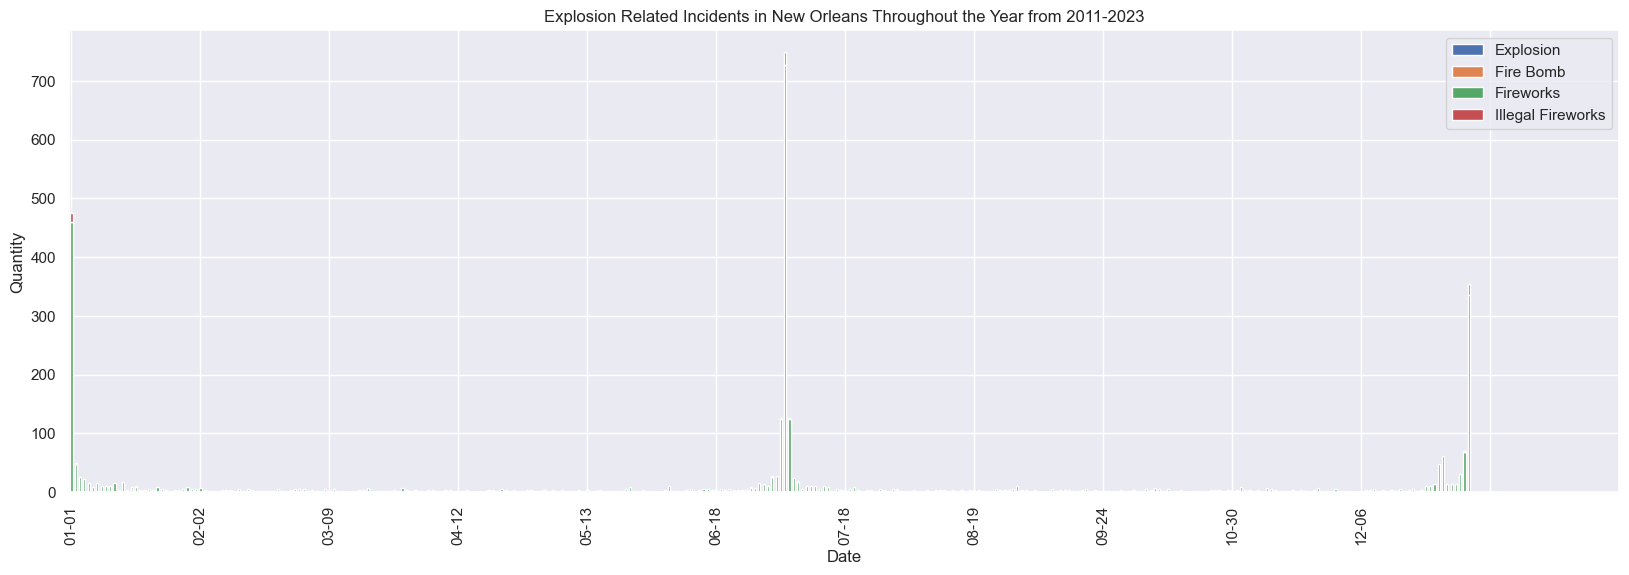

In [42]:
# create stacked bar plot of each kind of explosion-related incident for each day during the year over all of the data
ax = explosions_nested_df.unstack().plot(kind = "bar", stacked = True, figsize = (20,6))
xtick_interval = 30
ax.set_xticks(range(0, 365, xtick_interval));
ax.set_ylabel("Quantity")
ax.set_title("Explosion Related Incidents in New Orleans Throughout the Year from 2011-2023")
ax.legend(["Explosion", "Fire Bomb", "Fireworks", "Illegal Fireworks"]);

While there is a dramatic spike around the fourth of July, there is also noticeable additional activity around Christmas and New Years. Other than that, explosion related incedents are relatively rare throughout the rest of the year. While this pattern of activity is seasonal and shows a clear temporal pattern, it can be explained by the incidence of holidays much better than climate patterns thoughout the year.

Let's now examine incidents that have a direct causal relationship with the weather. We can query from the incident reports in a similar way any incidents that contain the word "FLOOD" in the label.

In [43]:
# get all incidents that mention 'FLOOD'
floods_df = calls_for_service[["TypeText", "TimeCreate"]].copy()[calls_for_service["TypeText"].str.contains('FLOOD')]
floods_df["TypeText"].value_counts()

TypeText
FLOOD EVENT                     2898
FLOODED STREET                   121
FLOODED VEHICLE                   35
FLOODED VEHICLE (NOT MOVING)       1
Name: count, dtype: int64

There were 3231 flood related events, with 135 flooded streets, and 71 flooded vehicles. We can extract the date and month of each event, and get the quantity for each day in all years in the same way that we did for the explosion data.

In [44]:
# extract month, day from datetime objects
floods_df["Date"] = floods_df["TimeCreate"].dt.strftime('%m-%d')
floods_df.head()

,TypeText,TimeCreate,Date
14553,FLOOD EVENT,2020-05-23 21:26:31,05-23
35718,FLOOD EVENT,2020-05-15 00:45:38,05-15
35725,FLOOD EVENT,2020-05-15 00:49:22,05-15
35744,FLOOD EVENT,2020-05-15 01:08:16,05-15
35747,FLOOD EVENT,2020-05-15 01:12:54,05-15


Again, we count the number of each type of event by each day, and reindex over these attributes.

In [45]:
# get quantity of each kind of flood-related events for any given date in a year
floods_nested_df = pd.DataFrame(floods_df.groupby(["Date", "TypeText"])["TypeText"].count())
floods_nested_df.rename(columns = {"Date" : "Date", "TypeText": "TypeText", "TypeText": "Quantity"}, inplace = True)
floods_nested_df.head()

,,Quantity
Date,TypeText,
01-04,FLOOD EVENT,1
01-07,FLOOD EVENT,4
01-10,FLOOD EVENT,5
01-12,FLOOD EVENT,1
01-23,FLOODED STREET,1


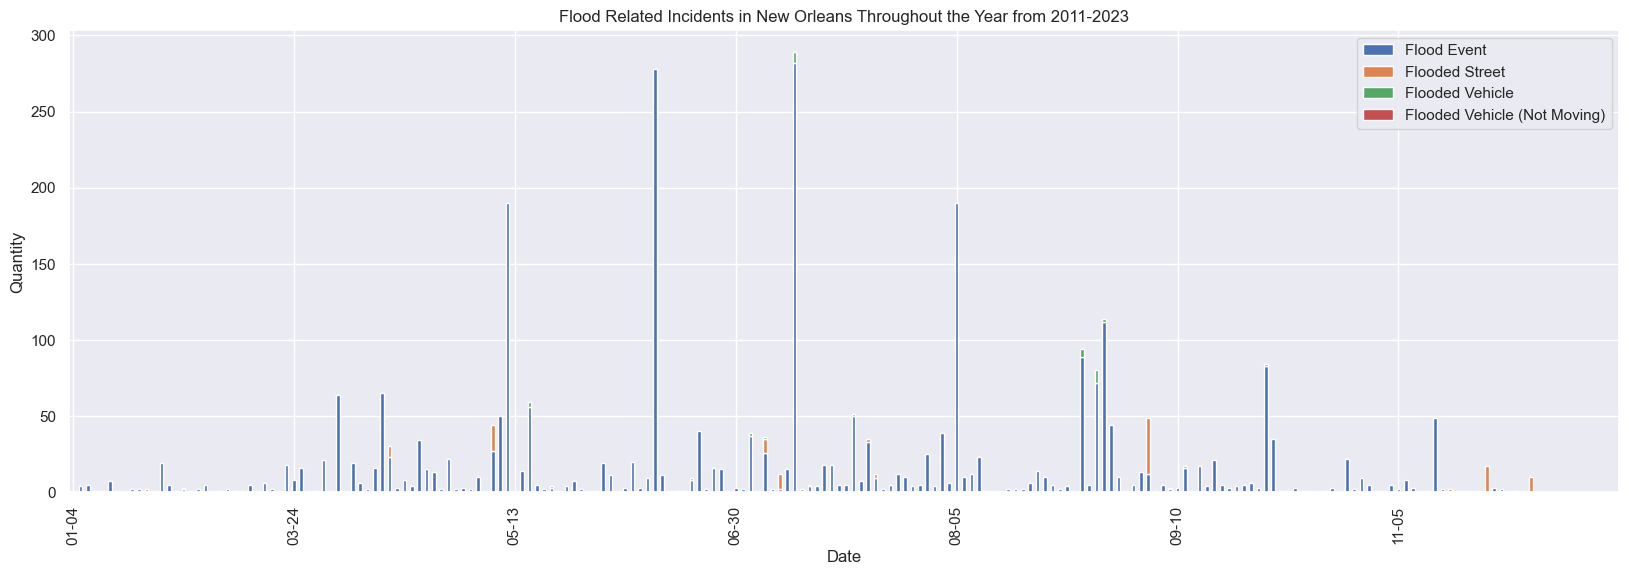

In [46]:
# create stacked bar plot of each kind of flood-related incident for each day during the year over all of the data
ax = floods_nested_df.unstack().plot(kind = "bar", stacked = True, figsize = (20,6))
xtick_interval = 30
ax.set_xticks(range(0, len(floods_nested_df), xtick_interval));
ax.set_ylabel("Quantity")
ax.set_title("Flood Related Incidents in New Orleans Throughout the Year from 2011-2023")
ax.legend(["Flood Event", "Flooded Street", "Flooded Vehicle", "Flooded Vehicle (Not Moving)"]);

Obviously, the presence of flooding is clearly related to the presence of weather events. As rain increases throughout the summer, there are more days with a higher number of flood related events, even among the days with abnormally high quantities. However, within that broader trend, the existence of the days with a much larger quantity of incidents cannot be explained by seasonal changes alone. It is more likely that these spikes are caused by individual weather events such as storms that exist within the broader seasonal trends.

## Data Matching

For a crime, given the date it occurred on, match it to weather from that day that is the closest geographical distance. We can do this by creating a custom function that takes in a row of the calls dataframe, extracts the date, latitude, and longitue of the entry, and then gets all weather from stations on that day. Of this list, we can then find the closest station by euclidean distance, and return the identifier for that station.

The calls for service dataframe is pretty large. Matching these entities will take awhile ***(>30 Minutes)***, even though we've vectorized our function - to save time, let's only run the match once, and then save it externally. We can then check if the table exists every time we run the cell, and if so, just load it and bypass generating the pairings more than once. 

In [47]:
# get rate sof null values for all attributes
(weather.isnull().mean() * 100)

Name                     0.000000
Latitude                 0.000000
Longitude                0.000000
Elevation                0.000000
AverageDailyWind        63.303377
NumDaysPrecipAvg        98.658376
FastestWindTime         98.705226
MultidayPrecipTotal     98.679671
PeakGustTime            87.720942
Precipitation            1.499212
Snowfall                80.361174
MinSoilTemp             99.872226
TimeAvgTemp             83.670514
TimeMaxTemp             43.017164
TimeMinTemp             43.064015
TempAtObs               81.042634
2MinMaxWindDirection    63.239491
5MinMaxWindDirection    63.367264
2MinMaxWindSpeed        63.239491
5MinMaxWindSpeed        63.367264
Fog                      0.000000
Heavy Fog                0.000000
Thunder                  0.000000
Ice Pellets              0.000000
Hail                     0.000000
Rime                     0.000000
Smoke                    0.000000
Tornado                  0.000000
High Wind                0.000000
Mist          

In [48]:
#entity matching

# warning, can take >30 mins
def match_weather(crime_row):
    # extract date, latitude, and longitude
    c_date = crime_row["DateCreate"]
    c_lat = crime_row["Latitude"]
    c_long = crime_row["Longitude"]
    # try to find weather on that day
    
    try:
        weather_by_day = weather.loc[c_date]
    except KeyError:
        return np.nan
    
    # if weather exists, get closest station identifier
    euc_distances = np.sqrt((weather_by_day['Latitude'] - c_lat) ** 2 + (weather_by_day['Longitude'] - c_long) ** 2)
    closest_station = euc_distances.idxmin()
    
    return(closest_station)

                                                     

In [49]:
match_table_path = '../data/match_table.csv'

calls_for_service["DateCreate"] = calls_for_service["TimeCreate"].dt.floor('D')

if os.path.exists(match_table_path):
    print("Loading Cached Entity Matching...")
    match_table = pd.read_csv(match_table_path)
    calls_for_service = calls_for_service.merge(match_table, on = "NOPD_Item", how = "outer")
    
else:
    print("Generating Entity Matching...")
    calls_for_service["ClosestStation"] = calls_for_service.progress_apply(match_weather, axis = 1)
    # If the file doesn't exist, save the DataFrame as a CSV
    match_table = calls_for_service[["NOPD_Item", "ClosestStation"]]
    match_table.to_csv(match_table_path, index=False)
    print("Dumping Relational Table to %s" %match_table_path)

Loading Cached Entity Matching...


In [50]:
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude,Latitude,SimpleType,DateCreate,PairedStation
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510,Status,2020-01-28,US1LAOR0006
1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 01:37:16,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN,-90.108405,29.959968,Complaints/Environment,2020-01-01,USW00012930
2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,2020-01-17 21:18:41,2020-01-17 21:18:41,2020-01-17 21:18:47,2020-01-17 21:18:54,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN,-90.065113,29.953238,Status,2020-01-17,US1LAOR0009
3,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,2020-01-16 17:09:05,2020-01-16 17:09:43,2020-01-16 17:16:07,2020-01-16 22:49:37,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN,-90.020901,30.009734,Violent Crime,2020-01-16,USW00053917
4,A3444420,20,AUTO ACCIDENT,1E,20,AUTO ACCIDENT,1E,3666298.0,529693.0,2020-01-27 19:59:59,2020-01-27 20:02:05,2020-01-27 20:14:58,2020-01-27 21:19:56,RTF,REPORT TO FOLLOW,N,2L04,Broadway St & S Claiborne Ave,70125.0,2,POINT (-90.11613127 29.95092657),NaN,NaN,-90.116131,29.950927,Accidents/Traffic Safety,2020-01-27,US1LAOR0014


Now that we have the matched station information, the combination of a weather station and a day can uniquely identify an observation in either table. With this, we can finally merge the two dataframes on the combination of these two keys.

In [51]:
calls_weather_master = pd.merge(calls_for_service, weather, left_on = ["DateCreate", "PairedStation"], right_on = ["Date", "Station"])

In [52]:
calls_weather_master.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude_x,Latitude_x,SimpleType,DateCreate,PairedStation,Name,Latitude_y,Longitude_y,Elevation,AverageDailyWind,NumDaysPrecipAvg,FastestWindTime,MultidayPrecipTotal,PeakGustTime,Precipitation,Snowfall,MinSoilTemp,TimeAvgTemp,TimeMaxTemp,TimeMinTemp,TempAtObs,2MinMaxWindDirection,5MinMaxWindDirection,2MinMaxWindSpeed,5MinMaxWindSpeed,Fog,Heavy Fog,Thunder,Ice Pellets,Hail,Rime,Smoke,Tornado,High Wind,Mist,Drizzle,Rain,Snow,Ground Fog
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510,Status,2020-01-28,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,A3605320,18,TRAFFIC INCIDENT,1J,18,TRAFFIC INCIDENT,1J,3677293.0,536895.0,2020-01-28 23:40:43,2020-01-28 23:40:43,2020-01-28 23:40:43,2020-01-29 00:01:34,NAT,Necessary Action Taken,Y,1J03,026XX Saint Ann St,70119.0,1,POINT (-90.08116628 29.97040355),NaN,NaN,-90.081166,29.970404,Accidents/Traffic Safety,2020-01-28,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,A3557120,58,RETURN FOR ADDITIONAL INFO,0A,58,RETURN FOR ADDITIONAL INFO,1I,3679778.0,526277.0,2020-01-28 16:28:00,2020-01-28 21:33:43,2020-01-28 21:33:48,2020-01-28 23:01:01,NAT,Necessary Action Taken,N,6E04,012XX Saint Charles Ave,70130.0,6,POINT (-90.07368951 29.94113385),NaN,NaN,-90.073690,29.941134,Status,2020-01-28,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,A3600220,58,RETURN FOR ADDITIONAL INFO,1I,58,RETURN FOR ADDITIONAL INFO,1I,3692978.0,529591.0,2020-01-28 22:23:24,2020-01-28 22:23:24,2020-01-28 22:23:24,2020-01-28 22:52:46,NAT,Necessary Action Taken,Y,4H02,024XX Sanctuary Dr,70114.0,4,POINT (-90.03189416 29.94983828),NaN,NaN,-90.031894,29.949838,Status,2020-01-28,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,A3583520,TS,TRAFFIC STOP,1J,TS,TRAFFIC STOP,1J,3705091.0,512746.0,2020-01-28 19:33:37,2020-01-28 19:33:37,2020-01-28 19:33:37,2020-01-28 19:45:08,NAT,Necessary Action Taken,Y,4D05,057XX Tullis Dr,70131.0,4,POINT (-89.99426931 29.90313678),NaN,NaN,-89.994269,29.903137,Accidents/Traffic Safety,2020-01-28,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Modeling

In [53]:
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival,Longitude,Latitude,SimpleType,DateCreate,PairedStation
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN,-90.045256,29.947510,Status,2020-01-28,US1LAOR0006
1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 01:37:16,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN,-90.108405,29.959968,Complaints/Environment,2020-01-01,USW00012930
2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,2020-01-17 21:18:41,2020-01-17 21:18:41,2020-01-17 21:18:47,2020-01-17 21:18:54,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN,-90.065113,29.953238,Status,2020-01-17,US1LAOR0009
3,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,2020-01-16 17:09:05,2020-01-16 17:09:43,2020-01-16 17:16:07,2020-01-16 22:49:37,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN,-90.020901,30.009734,Violent Crime,2020-01-16,USW00053917
4,A3444420,20,AUTO ACCIDENT,1E,20,AUTO ACCIDENT,1E,3666298.0,529693.0,2020-01-27 19:59:59,2020-01-27 20:02:05,2020-01-27 20:14:58,2020-01-27 21:19:56,RTF,REPORT TO FOLLOW,N,2L04,Broadway St & S Claiborne Ave,70125.0,2,POINT (-90.11613127 29.95092657),NaN,NaN,-90.116131,29.950927,Accidents/Traffic Safety,2020-01-27,US1LAOR0014


In [80]:
cfs_ml = calls_for_service[["NOPD_Item", "TimeCreate", "Zip", "Longitude", "Latitude", "SimpleType", "PairedStation", "DateCreate"]]
cfs_ml.head()

,NOPD_Item,TimeCreate,Zip,Longitude,Latitude,SimpleType,PairedStation,DateCreate
0,A3472220,2020-01-28 01:37:20,70114.0,-90.045256,29.947510,Status,US1LAOR0006,2020-01-28
1,A0000220,2020-01-01 00:00:42,70125.0,-90.108405,29.959968,Complaints/Environment,USW00012930,2020-01-01
2,A2190820,2020-01-17 21:18:41,70130.0,-90.065113,29.953238,Status,US1LAOR0009,2020-01-17
3,A2029120,2020-01-16 17:09:05,70126.0,-90.020901,30.009734,Violent Crime,USW00053917,2020-01-16
4,A3444420,2020-01-27 19:59:59,70125.0,-90.116131,29.950927,Accidents/Traffic Safety,US1LAOR0014,2020-01-27


In [81]:
cfs_ml.shape

(4215039, 8)

In [82]:
weather.head()

Name  Latitude  \
Date       Station                                                       
2023-09-29 USW00012930            NEW ORLEANS AUDUBON, LA US  29.91660   
           USW00012916            NEW ORLEANS AIRPORT, LA US  29.99755   
           US1LAOR0014            NEW ORLEANS 3.8 WSW, LA US  29.93772   
           US1LAOR0009              NEW ORLEANS 5.0 N, LA US  30.01515   
2023-09-28 USW00053917  NEW ORLEANS LAKEFRONT AIRPORT, LA US  30.04934   

                        Longitude  Elevation  AverageDailyWind  \
Date       Station                                               
2023-09-29 USW00012930 -90.130200        6.1               NaN   
           USW00012916 -90.277720       -1.0               NaN   
           US1LAOR0014 -90.131310        2.1               NaN   
           US1LAOR0009 -90.065586        0.6               NaN   
2023-09-28 USW00053917 -90.028990        0.9             15.43   

                        NumDaysPrecipAvg  FastestWindTime  \
Date       Station                                          
2023-09-29 USW00012930               NaN              NaN   
           USW00012916               NaN              NaN   
           US1LAOR0014               NaN              NaN   
           US1LAOR0009               NaN              NaN   
2023-09-28 USW00053917               NaN              NaN   

                        MultidayPrecipTotal  PeakGustTime  Precipitation  \
Date       Station                                                         
2023-09-29 USW00012930                  NaN           NaN            0.0   
           USW00012916                  NaN           NaN            NaN   
           US1LAOR0014                  NaN           NaN            0.0   
           US1LAOR0009                  NaN           NaN            0.0   
2023-09-28 USW00053917                  NaN        1815.0            0.0   

                        Snowfall  MinSoilTemp  TimeAvgTemp  TimeMaxTemp  \
Date       Station                                                        
2023-09-29 USW00012930       NaN          NaN          NaN         85.0   
           USW00012916       NaN          NaN         78.0          NaN   
           US1LAOR0014       0.0          NaN          NaN          NaN   
           US1LAOR0009       0.0          NaN          NaN          NaN   
2023-09-28 USW00053917       NaN          NaN          NaN         87.0   

                        TimeMinTemp  TempAtObs  2MinMaxWindDirection  \
Date       Station                                                     
2023-09-29 USW00012930         73.0       73.0                   NaN   
           USW00012916          NaN        NaN                   NaN   
           US1LAOR0014          NaN        NaN                   NaN   
           US1LAOR0009          NaN        NaN                   NaN   
2023-09-28 USW00053917         77.0        NaN                  60.0   

                        5MinMaxWindDirection  2MinMaxWindSpeed  \
Date       Station                                               
2023-09-29 USW00012930                   NaN               NaN   
           USW00012916                   NaN               NaN   
           US1LAOR0014                   NaN               NaN   
           US1LAOR0009                   NaN               NaN   
2023-09-28 USW00053917                  90.0              21.9   

                        5MinMaxWindSpeed    Fog  Heavy Fog  Thunder  \
Date       Station                                                    
2023-09-29 USW00012930               NaN  False      False    False   
           USW00012916               NaN  False      False    False   
           US1LAOR0014               NaN  False      False    False   
           US1LAOR0009               NaN  False      False    False   
2023-09-28 USW00053917              25.9  False      False    False   

                        Ice Pellets   Hail   Rime  Smoke  Tornado  High Wind  \
Date       Station                       

In [92]:
weather.groupby(by = "Station")["Precipitation"].unique().to_frame()

,Precipitation
Station,
US1LAOR0003,"[0.0, 0.5, 0.56, 0.01, 3.32, nan, 0.84, 0.02, ..."
US1LAOR0006,"[0.0, 0.12, 0.55, nan, 0.06, 0.09, 1.73, 0.18,..."
US1LAOR0009,"[0.0, 0.21, 0.05, 0.3, 5.2, 0.11, 1.3, 2.9, 0...."
US1LAOR0012,"[1.11, 0.71, 2.67, 2.46, 2.14, nan, 1.52, 0.07..."
US1LAOR0014,"[0.0, 0.71, 0.03, 2.77, 4.26, 0.22, 0.12, 0.01..."
US1LAOR0016,"[1.2, 0.54, 0.22, 0.15, 3.12, 2.45, 2.64, 0.39..."
US1LAOR0019,"[0.0, 0.25, 0.5, 0.1, 0.05, 0.15, 1.05, 0.7, 0..."
USC00166666,"[0.0, 0.7, 0.08, 0.52, 0.73, 0.5, 1.05, 0.41, ..."
USW00012916,"[nan, 0.0, 2.45, 0.07, 0.02, 0.46, 0.41, 0.01,..."


In [89]:
len(weather["Precipitation"].unique())

404

In [83]:
weather_ml = weather.reset_index()
weather_ml.head()

,Date,Station,Name,Latitude,Longitude,Elevation,AverageDailyWind,NumDaysPrecipAvg,FastestWindTime,MultidayPrecipTotal,PeakGustTime,Precipitation,Snowfall,MinSoilTemp,TimeAvgTemp,TimeMaxTemp,TimeMinTemp,TempAtObs,2MinMaxWindDirection,5MinMaxWindDirection,2MinMaxWindSpeed,5MinMaxWindSpeed,Fog,Heavy Fog,Thunder,Ice Pellets,Hail,Rime,Smoke,Tornado,High Wind,Mist,Drizzle,Rain,Snow,Ground Fog
0,2023-09-29,USW00012930,"NEW ORLEANS AUDUBON, LA US",29.91660,-90.130200,6.1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,85.0,73.0,73.0,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2023-09-29,USW00012916,"NEW ORLEANS AIRPORT, LA US",29.99755,-90.277720,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2023-09-29,US1LAOR0014,"NEW ORLEANS 3.8 WSW, LA US",29.93772,-90.131310,2.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2023-09-29,US1LAOR0009,"NEW ORLEANS 5.0 N, LA US",30.01515,-90.065586,0.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2023-09-28,USW00053917,"NEW ORLEANS LAKEFRONT AIRPORT, LA US",30.04934,-90.028990,0.9,15.43,NaN,NaN,NaN,1815.0,0.0,NaN,NaN,NaN,87.0,77.0,NaN,60.0,90.0,21.9,25.9,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [84]:
cfs_ml= pd.merge(cfs_ml, weather_ml[["Date", "Station", "Precipitation"]], left_on = ["DateCreate", "PairedStation"], right_on = ["Date", "Station"], how = 'inner')


cfs_ml["Precipitation"].unique()

array([0.01, 0.1 , 0.  , 0.59, 0.09, 0.19, 0.07, 0.02, 0.05,  nan, 0.03,
       0.12, 1.26, 2.42, 1.78, 0.72, 1.96, 0.06, 1.95, 0.55, 0.49, 0.3 ,
       0.51, 0.25, 2.11, 0.14, 0.08, 0.32, 1.5 , 1.9 , 1.03, 0.6 , 0.2 ,
       0.33, 2.62, 3.24, 4.76, 1.39, 0.48, 0.31, 0.41, 0.63, 1.35, 1.15,
       0.69, 0.85, 4.21, 0.35, 0.18, 0.24, 1.21, 0.39, 1.16, 0.89, 3.86,
       3.21, 0.99, 0.13, 0.67, 1.22, 0.27, 0.16, 0.23, 0.38, 0.15, 1.6 ,
       0.82, 0.42, 2.36, 2.64, 2.8 , 4.  , 1.92, 1.09, 3.26, 0.34, 4.46,
       0.22, 2.66, 0.29, 3.81, 0.96, 0.47, 0.21, 1.14, 1.34, 0.37, 2.07,
       0.65, 0.9 , 0.61, 0.43, 0.11, 0.04, 2.14, 0.93, 2.3 , 0.64, 1.27,
       1.29, 0.81, 0.76, 2.82, 0.28, 1.52, 0.98, 0.58, 0.95, 1.25, 1.08,
       0.46, 1.48, 1.02, 3.44, 0.4 , 1.24, 0.91, 1.81, 1.33, 3.22, 0.74,
       3.39, 1.28, 1.44, 0.87, 0.26, 0.78, 0.83, 1.07, 0.92, 0.44, 1.75,
       0.56, 0.45, 0.68, 0.57, 0.66, 0.53, 1.13, 0.52, 2.04, 1.91, 2.98,
       0.54, 1.18, 0.8 , 1.17, 1.31, 0.73, 1.57, 0.

### Effect of Precipitation
First, one of the most elementary distinctions we can make is whether or not the precipitation on that day was 0 or greater than 0. How does this affect the quantity of each type of incident on any given day?

In [54]:
precip_data = calls_weather_master.loc[calls_weather_master["Precipitation"]>0]
no_precip_data = calls_weather_master.loc[calls_weather_master["Precipitation"] == 0]

# how many of each kind of incident were there on each day in each data set?
precip_data_counts = precip_data.groupby(by = ["DateCreate"])["SimpleType"].value_counts().to_frame()
no_precip_data_counts = no_precip_data.groupby(by = ["DateCreate"])["SimpleType"].value_counts().to_frame()

# in each dataset, on average, how many were of each type on each day?
avg_precip_data_counts = precip_data_counts.groupby(by = ["SimpleType"]).mean()
avg_no_precip_data_counts = no_precip_data_counts.groupby(by = ["SimpleType"]).mean()
 

total_avg_precip_counts = pd.merge(avg_precip_data_counts, avg_no_precip_data_counts, on = "SimpleType", suffixes = ("_precip", "_noprecip"))
total_avg_precip_counts.columns = ["PrecipPresent", "PrecipNotPresent"]

total_avg_precip_counts.head()

,PrecipPresent,PrecipNotPresent
SimpleType,,
Accidents/Traffic Safety,49.928854,65.570949
Alarms,26.324538,34.521739
Alcohol,1.398551,1.350427
Complaints/Environment,119.301837,157.387823
Domestic Violence,17.045213,22.742857


In [55]:
melted_precip_counts = pd.melt(total_avg_precip_counts.reset_index(), id_vars = "SimpleType", value_vars = ["PrecipPresent", "PrecipNotPresent"], var_name = "Precip", value_name = "AvgCount")
melted_precip_counts.head()

,SimpleType,Precip,AvgCount
0,Accidents/Traffic Safety,PrecipPresent,49.928854
1,Alarms,PrecipPresent,26.324538
2,Alcohol,PrecipPresent,1.398551
3,Complaints/Environment,PrecipPresent,119.301837
4,Domestic Violence,PrecipPresent,17.045213


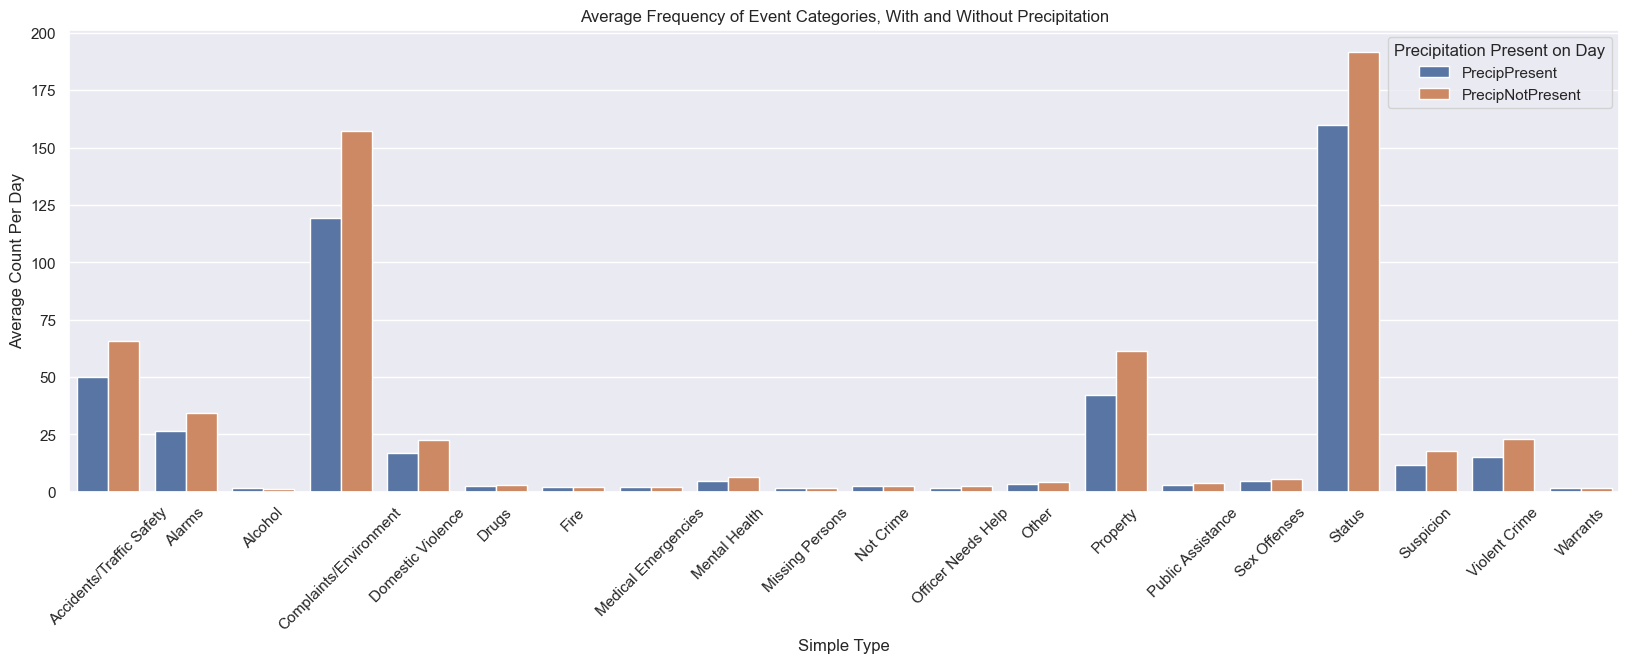

In [56]:
plt.figure(figsize = (20,6))
precip_diffs = sns.barplot(melted_precip_counts, x = "SimpleType", y = "AvgCount", hue = "Precip")
for item in precip_diffs.get_xticklabels():
    item.set_rotation(45)
precip_diffs.set(xlabel = "Simple Type", ylabel = "Average Count Per Day", title = "Average Frequency of Event Categories, With and Without Precipitation")

plt.legend(title = "Precipitation Present on Day")
plt.show()

In [57]:
precip_data_raw = precip_data_counts.droplevel("DateCreate")
no_precip_data_raw = no_precip_data_counts.droplevel("DateCreate")

precip_data_raw.head(20)

,count
SimpleType,
Property,54
Complaints/Environment,53
Accidents/Traffic Safety,29
Status,25
Fire,22
Alarms,13
Domestic Violence,11
Violent Crime,11
Suspicion,6


In [58]:
precip_data_raw.index.unique()

Index(['Property', 'Complaints/Environment', 'Accidents/Traffic Safety',
       'Status', 'Fire', 'Alarms', 'Domestic Violence', 'Violent Crime',
       'Suspicion', 'Other', 'Drugs', 'Alcohol', 'Sex Offenses', 'Warrants',
       'Missing Persons', 'Not Crime', 'Officer Needs Help',
       'Public Assistance', 'Medical Emergencies', 'Mental Health'],
      dtype='object', name='SimpleType')

In [59]:
# t_tests = pd.DataFrame(columns = ["SimpleType", "TVal", "PVal"])
t_tests.set_index(["SimpleType"], inplace = True)

t_tests.head()

for i, kind in enumerate(precip_data_raw.index.unique()):
    subset_precip = precip_data_raw.loc[kind]
    subset_noprecip = no_precip_data_raw.loc[kind]
    ttest = stats.ttest_ind(subset_precip, subset_noprecip)
    tval, pval = ttest.statistic[0], ttest.pvalue[0]
    temp_dict = pd.DataFrame({"TVal": tval, "Pval": pval}, index = [kind])
    t_tests = pd.concat([t_tests, temp_dict], ignore_index = False)
    
    #print(tval, pval)
    #display(subset_precip, subset_noprecip)
    pass

display(t_tests)

NameError: name 't_tests' is not defined

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

t_hist = sns.barplot(data = t_tests, x = t_tests.index, y = "TVal", ax = axes[0])
p_hist = sns.barplot(data = t_tests, x = t_tests.index, y = "PVal", ax = axes[1])

### Effect of Temperature on the Rates of Violent Crime

In [ ]:
calls_weather_master.head()

In [ ]:
violent_incidents = calls_weather_master.loc[calls_weather_master["SimpleType"] == 'Violent Crime']
violent_incidents.head()

In [ ]:
weather["TimeMaxTemp"].isnull().sum() * 100 / len(weather["TimeMaxTemp"])

In [ ]:
weather.groupby(by = "Station")["TimeMaxTemp"].mean()

In [ ]:
temp_df = calls_for_service[["NOPD_Item", "Longitude", "Latitude", "DateCreate", "SimpleType"]].copy().dropna(how = 'any')


temp_df.head()

In [ ]:
temp_subselect = weather.loc[weather.index.get_level_values(1) == "USW00012930"][["TimeAvgTemp", "TimeMaxTemp", "TimeMinTemp"]]

temp_df = pd.merge(temp_df, temp_subselect, left_on = "DateCreate", right_on = "Date", how = "outer").progress_apply(lambda x: x)


In [ ]:
temp_df.head()

In [ ]:
plt.figure(figsize = (20,6))
temp_hist = sns.histplot(data = temp_df, x = "TimeMaxTemp")

In [ ]:
temp_df["IsViolent"] = temp_df["SimpleType"] == "Violent Crime"
temp_df.head(10)

In [ ]:
plt.figure(figsize = (20,6))
viol_temp_hist = sns.histplot(data = temp_df, x = "TimeMaxTemp", hue = "IsViolent", stat = "density", multiple = "dodge", common_norm = False)
viol_temp_hist.set(xlabel = "Maximum Temperature on Day (Fahrenheit)", ylabel = "Porportion of Incidents", title = "Relative Proportions of Violent and Non-Violent Incidents Across Maximum Temperatures on Day");

In [ ]:
plt.figure(figsize = (20,6))
viol_temp_hist = sns.histplot(data = temp_df, x = "TimeMinTemp", hue = "IsViolent", stat = "density", multiple = "dodge", common_norm = False)
viol_temp_hist.set(xlabel = "Minimum Temperature on Day (Fahrenheit)", ylabel = "Porportion of Incidents", title = "Relative Proportions of Violent and Non-Violent Incidents Across Minimum Temperatures on Day");

### ANALYSIS 3

In [ ]:
calls_for_service.head()

### Analysis 4

Digging into the effects of temperature and violent crime, lets look at the overall spread of violent crimes throughout the city when the temperature is above or below a certain threshold. 

In [ ]:
violent_incidents.head()

In [ ]:
weather.groupby(by = "Station")["TimeMaxTemp"].mean()

Let's narrow our search down to violent crimes where the max temperature was recorded

In [ ]:
violent_incidents = violent_incidents[violent_incidents["TimeMaxTemp"].isnull()==False]
violent_incidents["TimeMaxTemp"].mean()